In [1]:
# Change Working Directory To Allow knn Imports
import os 
os.chdir('../')

In [2]:
import numpy as np
import matplotlib.pyplot as plt

sample_data = np.array([[4, -2], [5, 5], [8, 7], [-6, -1], [-1, -3], [-4,-8]]).astype(np.float)
sample_label= np.array([1, 1, 1, 0, 0, 0]).astype(np.float)

def plot_ball_tree(data, circles):
    fig, ax = plt.subplots()

    # Axis
    plt.axhline(0, color="black")
    plt.axvline(0, color="black")

    # Set X and Y Axis Bounds
    plt.xlim(-10,  10)
    plt.ylim(-10, 10)

    # Add Data
    plt.scatter(data[:, 0], data[:, 1])

    # Add Circle
    for circle in circles:
        circle1 = plt.Circle(circle[0], circle[1], color='r', fill=False)
        ax.add_artist(circle1)

    plt.show()
 
plot_ball_tree(sample_data, [[(1,1), 3]])



<Figure size 640x480 with 1 Axes>

[[-4. -8.]]
[8. 7.]
[-4. -8.]
[12. 15.]
[  18.  135.  201.  -87.  -57. -168.]
[[-6. -1.]
 [-4. -8.]
 [-1. -3.]]
[[ 4. -2.]
 [ 5.  5.]
 [ 8.  7.]]
[ 1.         -0.33333333]
10.137937550497032


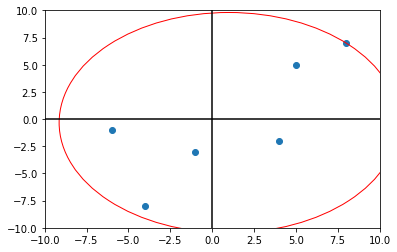

In [6]:
from knn.distance_metrics import euclidean_pairwise

# Pick Item Randomly
rand_index = np.random.choice(sample_data.shape[0], 1, replace=False) 
rand_point = sample_data[rand_index, :]
print(rand_point)

distances = euclidean_pairwise(sample_data, rand_point)
ind_of_max_dist = np.argmax(distances)
max_vector_1 = sample_data[ind_of_max_dist, :]
print(max_vector_1)

distances = euclidean_pairwise(sample_data, max_vector_1[np.newaxis, :])
ind_of_max_dist = np.argmax(distances)
max_vector_2 = sample_data[ind_of_max_dist, :]
print(max_vector_2)


# Project All Data
proj_vector = max_vector_1-max_vector_2
print(proj_vector)

proj_data = sample_data.dot(proj_vector)
print(proj_data)

# Median
median_ind = np.argpartition(proj_data, proj_data.size//2)
lower_than_med_inds = median_ind[:proj_data.size//2]
greater_than_med_inds = median_ind[proj_data.size//2:]

# Left Side
print(sample_data[lower_than_med_inds])

# Right Size
print(sample_data[greater_than_med_inds])


# Make Circle
center = np.mean(sample_data, axis=0)
print(center)
radius = np.max(euclidean_pairwise(sample_data, center[np.newaxis, :]))
print(radius)

plot_ball_tree(sample_data, [[center, radius ]])

[[array([ 1.        , -0.33333333]), 10.137937550497032], [array([-3.66666667, -4.        ]), 4.013864859597431], [array([-2.5, -5.5]), 2.9154759474226504], [array([5.66666667, 3.33333333]), 5.587684871413404], [array([4.5, 1.5]), 3.5355339059327378]]


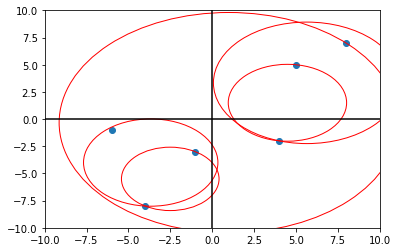

In [9]:
class BallTreeNode:
    def __init__(self):
        self.center = None
        self.radius = None
        self.left_child = None
        self.right_child = None
        self.leaf_data = None

def split_tree(data, leaf_size):
    
    if data.shape[0] <= leaf_size:
        leaf_node = BallTreeNode()
        center = np.mean(data, axis=0)
        radius = np.max(euclidean_pairwise(data, center[np.newaxis, :]))
        leaf_node.center = center
        leaf_node.radius = radius
        leaf_node.leaf_data = data
        return leaf_node
    
    # Random Point x0
    rand_index = np.random.choice(data.shape[0], 1, replace=False) 
    rand_point = data[rand_index, :]
    
    # Find Maximal Point x1
    distances = euclidean_pairwise(data, rand_point)
    ind_of_max_dist = np.argmax(distances)
    max_vector_1 = data[ind_of_max_dist, :]
    
    # Find Maximal Point x2
    distances = euclidean_pairwise(data, max_vector_1[np.newaxis, :])
    ind_of_max_dist = np.argmax(distances)
    max_vector_2 = data[ind_of_max_dist, :]
    
    # Project Data
    proj_data = data.dot(max_vector_1-max_vector_2)
    
    # Find Median And Split Data
    median_ind = np.argpartition(proj_data, proj_data.size//2)
    lower_than_med_inds = median_ind[:proj_data.size//2]
    greater_than_med_inds = median_ind[proj_data.size//2:]
    
    # Create Circle
    center = np.mean(data, axis=0)
    radius = np.max(euclidean_pairwise(data, center[np.newaxis, :]))
    
    tree_node = BallTreeNode()
    tree_node.center = center
    tree_node.radius = radius
    tree_node.left_child = split_tree(data[lower_than_med_inds], leaf_size)
    tree_node.right_child = split_tree(data[greater_than_med_inds], leaf_size)
    
    return tree_node
   
def get_circles(ball_tree):
    
    node_list = [ball_tree]
    circle_list = []
    
    while len(node_list) != 0:
        current_node = node_list.pop()
        if current_node.leaf_data is None:
            circle_list.append([current_node.center, current_node.radius])
            node_list.append(current_node.left_child)
            node_list.append(current_node.right_child)
    
    return circle_list

tree = split_tree(sample_data, 1)

print(get_circles(tree))

plot_ball_tree(sample_data, get_circles(tree))

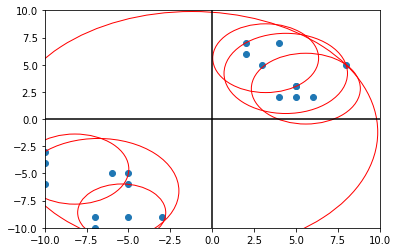

In [11]:
group_1 = np.random.randint(2, 10, (10, 2))
group_2 = np.random.randint(-10, -2, (10, 2))
rand_data = np.vstack((group_1, group_2)).astype(np.float)
tree = split_tree(rand_data, 3)
plot_ball_tree(rand_data, get_circles(tree))

In [14]:
import heapq

def query_ball_tree(target_vect, k, queue, curr_node):
    
    # Prune This Ball
    if euclidean_pairwise(target_vect, curr_node.center[np.newaxis,:]) - curr_node.radius >= -1*queue[0][0]:
        #print("Pruned")
        return queue
    
    # Currently A Leaf Node
    if curr_node.leaf_data is not None:
        #print("Leaf")
        for point in curr_node.leaf_data:
            dist = np.asscalar(euclidean_pairwise(target_vect, point[np.newaxis,:]))
            if dist < -1*queue[0][0]: 
                heapq.heappushpop(queue, (-1*dist, np.random.randint(9999999999), point))
         
    # Not Leaf So Explore Children
    else:
        #print("Non-Pruned Internal Node")
        
        child1 = curr_node.left_child
        child2 = curr_node.right_child
        
        child1_dist = euclidean_pairwise(child1.center[np.newaxis,:], target_vect)
        child2_dist = euclidean_pairwise(child2.center[np.newaxis,:], target_vect)
        
        if child1_dist < child2_dist:
            query_ball_tree(target_vect, k, queue, child1)
            query_ball_tree(target_vect, k, queue, child2)
        else:
            query_ball_tree(target_vect, k, queue, child2)
            query_ball_tree(target_vect, k, queue, child1)
        
        
test_point = np.array([1, -1])[np.newaxis, :].astype(np.float)       

k_size = 3

queue = []
for i in range(k_size):
    queue.append((-9999999999999, np.random.randint(9999999999999) ,np.array([9999999999999, 9999999999999])))
    #heapq.heappush(queue, (-1*np.asscalar(euclidean(test_point, sample_data[i, :][np.newaxis, :])) ,sample_data[i, :]))

query_ball_tree(test_point , k_size, queue, tree)

In [16]:
group_1 = np.random.randint(2, 10, (1000, 2))
group_2 = np.random.randint(-10, -2, (1000, 2))
rand_data = np.vstack((group_1, group_2)).astype(np.float)
%timeit tree = split_tree(rand_data, 3)
tree = split_tree(rand_data, 3)
%timeit query_ball_tree(test_point , k_size, queue, tree)
%timeit test = euclidean_pairwise(rand_data, test_point)

151 ms ± 6.73 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
740 µs ± 9.06 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
15.2 µs ± 86.4 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [17]:
from collections import Counter

class PriorityQueue:
    
    def __init__(self, is_min_heap=True):
        self.queue = []
        self.cnt = Counter()
        self.is_min_heap = is_min_heap
        
    def heappush(self, priority, value):
        self.cnt[priority] += 1
        q_priority = priority if self.is_min_heap  else -1*priority
        heapq.heappush(self.queue, (q_priority, self.cnt[priority] , value))
    
    def heappushpop(self, priority, value):
        self.cnt[priority] += 1
        q_priority = priority if self.is_min_heap  else -1*priority
        heapq.heappushpop(self.queue, (q_priority, self.cnt[priority] , value))
        
    def heappop(self):
        curr_top = heapq.heappop(self.queue)
        q_priority = curr_top[0] if self.is_min_heap  else -1*curr_top[0]
        return (q_priority, curr_top[2])
        
    def peektop(self):
        curr_top = self.queue[0]
        q_priority = curr_top[0] if self.is_min_heap  else -1*curr_top[0]
        return (q_priority, curr_top[2])
        
queue = PriorityQueue(False)
queue.heappush(1, 4)
queue.heappush(1, 4)
queue.heappush(3, 8)
queue.heappush(-1, 3)

queue.heappushpop(2, 8)
queue.heappop()
print(queue.queue)

[(-1, 1, 4), (-1, 2, 4), (1, 1, 3)]


In [23]:
# As A Function

def create_ball_tree(data, leaf_size):
    
    if data.shape[0] <= leaf_size:
        leaf_node = {}
        leaf_node["center"] = np.mean(data, axis=0)[np.newaxis, :]
        leaf_node["radius"] = np.max(euclidean_pairwise(data, leaf_node["center"]))
        leaf_node["data"] = data
        return leaf_node
    
    # Random Point x0
    rand_index = np.random.choice(data.shape[0], 1, replace=False) 
    rand_point = data[rand_index, :]
    
    # Find Maximal Point x1
    distances = euclidean_pairwise(data, rand_point)
    ind_of_max_dist = np.argmax(distances)
    max_vector_1 = data[ind_of_max_dist, :]
    
    # Find Maximal Point x2
    distances = euclidean_pairwise(data, max_vector_1[np.newaxis, :])
    ind_of_max_dist = np.argmax(distances)
    max_vector_2 = data[ind_of_max_dist, :]
    
    # Project Data
    proj_data = data.dot(max_vector_1-max_vector_2)
    
    # Find Median And Split Data
    median_ind = np.argpartition(proj_data, proj_data.size//2)
    lower_than_med_inds = median_ind[:proj_data.size//2]
    greater_than_med_inds = median_ind[proj_data.size//2:]
    
    # Create Circle
    center = np.mean(data, axis=0)
    radius = np.max(euclidean_pairwise(data, center[np.newaxis, :]))
    
    internal_node = {}
    internal_node["center"] = center[np.newaxis, :]
    internal_node["radius"] = radius
    internal_node["left_child"] = create_ball_tree(data[lower_than_med_inds], leaf_size)
    internal_node["right_child"] = create_ball_tree(data[greater_than_med_inds], leaf_size)
    
    return internal_node


def query_ball_tree(target_vect, k, queue, curr_node):
    
    # Prune This Ball
    if euclidean_pairwise(target_vect, curr_node["center"]) - curr_node["radius"] >= queue.peektop()[0]:
        return queue
    
    # Currently A Leaf Node
    if "data" in curr_node:
        dists = euclidean_pairwise(target_vect, curr_node["data"])
        for i, dist in enumerate(dists):
            if dist < queue.peektop()[0]: 
                queue.heappushpop(dist[0], curr_node["data"][i,:])
   
    # Not Leaf So Explore Children
    else:
        #print("Non-Pruned Internal Node")
        
        child1 = curr_node["left_child"]
        child2 = curr_node["right_child"]
        
        child1_dist = euclidean_pairwise(child1["center"], target_vect)
        child2_dist = euclidean_pairwise(child2["center"], target_vect)
        
        if child1_dist < child2_dist:
            query_ball_tree(target_vect, k, queue, child1)
            query_ball_tree(target_vect, k, queue, child2)
        else:
            query_ball_tree(target_vect, k, queue, child2)
            query_ball_tree(target_vect, k, queue, child1)
            

In [24]:
tree = create_ball_tree(sample_data, 2)

test_point = np.array([1, -1])[np.newaxis, :].astype(np.float)       

k_size = 5

queue = PriorityQueue(False)
for i in range(k_size):
    queue.heappush(9999999999999 ,np.array([9999999999999, 9999999999999]))

query_ball_tree(test_point , k_size, queue, tree)
print(queue.queue)

[(-8.602325267042627, 1, array([-4., -8.])), (-7.211102550927978, 1, array([5., 5.])), (-7.0, 1, array([-6., -1.])), (-2.8284271247461903, 1, array([-1., -3.])), (-3.1622776601683795, 1, array([ 4., -2.]))]
